**1** generate points

[[15.75856813 31.01384627  9.07570865 25.84345338 39.60374931 44.20618854
  11.9979941  22.07128339 28.46479138  6.09469328 38.0361135  30.18708864
   2.77330685 24.10929959 35.42075566 21.88568121 38.31676673  8.88777813
   7.3802056  41.67723162]]
[[36.99090153 31.01384627]
 [38.52632604  9.07570865]
 [31.59815771 25.84345338]
 [16.15539716 39.60374931]
 [35.14126011 44.20618854]
 [26.08012807 11.9979941 ]
 [49.69735904 22.07128339]
 [46.17085477 28.46479138]
 [30.28230976  6.09469328]]


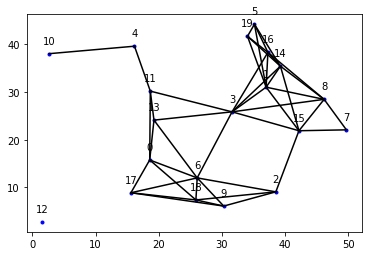

In [1]:
import numpy as np, datetime
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib inline

fieldSize = 50
numNodes = 20
maxDistance = 15

import random
random.seed(0)

xy = np.multiply(np.random.rand(2, numNodes), fieldSize)
print(xy[1:10, :])

# generate points
points = np.column_stack(xy)
print(points[1:10, :])

# plot points
plt.plot(xy[0], xy[1], 'b.')
label = 0
for x, y in zip(xy[0], xy[1]):
    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    label = label + 1

# plot connections
kdTree = spatial.cKDTree(points)
pairs = list(kdTree.query_pairs(maxDistance))

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')
    
for i in pairs:
    connectpoints(xy[0], xy[1], i[0], i[1])

plt.show()


**2** generate distances matrix

In [2]:
kdTree = spatial.cKDTree(points)
dists = kdTree.sparse_distance_matrix(kdTree, maxDistance)

# Randomize distances matrix (or not)
rdists = dists.toarray() #* np.random.normal(1, 0.1, dists.shape)

# Overall Strategy
- Simulate network traffic metrics
- Establish that a simple algorithm works
- Plot the results, and show that for different cases of N, number of samples, attacker fudge factor, things still work

# Simulate Network Traffic
What we will do here is get a list of all edges, and use the index of each edge pair going forward.
Anyway, given our sparse representation, we iterate N_samples times, where in each sample we
 - pick a random edge pair
 - calculate a new metric, based off a scaled poisson distribution (mean=1), times rdist[edge_pair]
 - calculate the running mean metric for the randomly picked edge pair.
    
The advantage of simulating traffic like this, even though we are just taking summary statistics for each edge pair, 
is that it gives us the ability to get a distribution for observed edge values,
and get a sense how well this method will work given certain asssumption about 
uncertainty. 

## Edge Pairs
For a given edge pair (source, target), I'm making the following assumptions
 - Source is the node that is reporting on the distance within the edge
 - edge distance as measured (source, target) is the same as (target, source). Thus the metric is communative. 
 


## Attacker Routine
In this algorithm, the attacker is specified as one node, lying about their metric by scaling down the metric by a given percentage. 
For instance, if node=2 is the attacker, for if edge pair (2, 15) came up, we would calculate the sampled matric then multiple it by the attacker_distance_boost.


In [3]:
# unique list of edges (unorderd)
rows, cols = np.nonzero(rdists)
edge_all = [[x[0], x[1]] for x in list(zip(rows, cols))]
edge_set = [(x[0],x[1]) for x in list(zip(rows, cols)) if (x[0] < x[1])]


In [4]:
# generate the dataset
N_samples = len(edge_all) * 30
attacker_distance_boost = 0.8
attacker_node = 1

# preallocate our random factors
poisson_shape_factor = 5
noise_factor = (np.random.poisson(poisson_shape_factor, N_samples) + \
                np.random.uniform(size=N_samples)) \
                / poisson_shape_factor

# pre-allocate a running count and average
count_pair = np.zeros(len(edge_all))
average_edge_sample = np.zeros(len(edge_all))
average_edge_known = [rdists[idx[0],idx[1]] for idx in edge_all]

#list_item = [query, target, distance_est]
for i in range(N_samples):
    idx_sample = random.choice(range(len(edge_all)))
    x_sample, y_sample = edge_all[idx_sample]
    sample_metric = rdists[x_sample, y_sample] * noise_factor[i]
    if x_sample == attacker_node:
        sample_metric *= attacker_distance_boost
    average_edge_sample[idx_sample] = average_edge_sample[idx_sample] + \
        (sample_metric - average_edge_sample[idx_sample])/(count_pair[idx_sample]+1)

    count_pair[idx_sample] = count_pair[idx_sample] + 1
    # print(x_sample, y_sample, sample_metric)

# Attacker Detection Algorithm
The algorithm to detect the compromised node is pretty simple. 
For a given node, we take the following steps:
1. get the (source, target) edges s.t. source is the node of interest
2. get the (source, target) edges s.t. target is the node of interest. 
3. For (1), this will be the (node, {target}) set, or all the measurements recorded by the node. (2) is the distance according to all nearby nodes.
4. Given the edges, get the vector of metrics as measured by the nodes, and the metrics as measured by neighbours. 
5. Use the distance function: fn(x,y) = mean(x - y) to derive the final measurement for a node, which compares what the node reports, and what its neighbours report. 

Note: There is probably a better distance function to use, mean(x - y) is pretty basic, and it could be worth looking at mean squared error as well. 
Further, the vector comparison is done on moments (mean of edge metric), but there might be a better way to integrate all the data in this, or another similiar calculation.

In [5]:
# For every node
 # get all (node -> neighbour)
 # get all (neighbour -> node)
 # compare the distance between these two vecs, what do we see?
edges_np = np.asarray(edge_all)
# pre-allocate metric distance array
measured_difference = np.zeros(numNodes)
for node in range(numNodes):
    # node -> neighbour
    node_neigh_idx = np.where(edges_np[:,0] == node)[0]
    neigh_node_idx = np.where(edges_np[:,1] == node)[0]
    node_neigh_samples = average_edge_sample[node_neigh_idx]
    neigh_node_samples = average_edge_sample[neigh_node_idx]
    if len(edges_np[node_neigh_idx,1]) == len(edges_np[neigh_node_idx,0]):
        measured_difference[node] = np.mean(node_neigh_samples - neigh_node_samples)
    else:
        print('skipping node w/ asymetric evidence: ' + str(node))

measured_difference[1:10]

/Users/jehan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jehan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([-1.66222113, -0.86744853, -0.04799739,  0.06929173, -0.35667566,
       -0.38297484,  0.33093586, -0.72810565,  0.08130698])

# Plot result
Finally, we can see our manipulated node, is not like the others!
The idea here is that we want to establish a distribution of normal edge pair metric differences, from which we can compare our attacker.

Looking at the results, it's easy to see that one attacker (red vertical line), who says they are 80% closer, is resulting in a significant anomaly.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
md = measured_difference[np.where(np.isfinite(measured_difference))[0]]
bin_width = (max(md) - min(md))/len(bin_edges)
plt.figure(figsize=[10,8])
hist,bin_edges = np.histogram(md)
plt.bar(bin_edges[:-1], hist, width=bin_width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('(Node -> Neigh) vs. (Neigh -> Node) metric differences\nAttacker is reporting 75% of actual speed\nvertical red line shows attacker',fontsize=15)
plt.axvline(ymin = 0, ymax = 120, x = measured_difference[attacker_node] + bin_width/2, color = "red")
plt.show()

NameError: name 'bin_edges' is not defined